# Topic Modeling

This notebook will document step by step different approaches to group documents in different topics using the **topic modeling** strategy.

## What exactly is Topic Modeling?

**Topic Modeling** is a technique used to discover the **distribution of uderlying topics** in a collection of documents.

Each topic is a collection of co-occuring words in a set of documents. The order of the words is not taken into account.

In [1]:
# Obtain the abstracts of the papers under data/pdfs

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
os.path.dirname(os.getcwd())

from pdf_analyzer.config_load import load_config
from pdf_analyzer.api import API
from omegaconf import OmegaConf
from pdf_analyzer.config_load import load_config

from get_paper_metadata import get_paper_metadata

In [2]:
server_config = load_config("config/api/grobid-server-config.yaml")
extract_config = load_config("config/api/api-base-config.yaml")
print("SERVER_CONFIG\n"+OmegaConf.to_yaml(server_config))
print("CLOUD_CONFIG\n"+OmegaConf.to_yaml(extract_config))

base_api = API.BaseAPI(extract_config,server_config)

abstracts = [get_paper_metadata(doc)['abstract'].strip() for doc in base_api.proccesed_files]

SERVER_CONFIG
url:
  protocol: http
  api_domain: yordi111nas.synology.me
  port: 8070

CLOUD_CONFIG
data:
  data_dir: data/PDFs
  format: .pdf
  recursive: true
grobid:
  cache: true
  cache_dir: data/xmls
  operation_key: processFulltextDocument
  format: .grobid.tei.xml
  recursive: true

GROBID server is up and running
data/xmls/PabloEscobar_5.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/word2vec.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/PabloEscobar_4.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/PabloEscobar_6.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/PabloEscobar_7.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/PabloEscobar_3.grobid.tei.xml already exist, skipping... (use --force to reprocess pdf input files)
data/xmls/Dont_stop_p

In [3]:
abstracts

["Collective memory of atrocities is a fractured and disputed terrain. In this article, we empirically explore the complex process of translating violent events that took place in Medellín during the 1980s and 1990s into collective memory. It examines the conflict between Medellín inhabitants' (in)ability to overcome trauma and shape their collective identity and the power of global media representations, exemplified by popular TV shows such as Narcos, to impose their narratives and consequently shape the present nature of the city. Drawing on original empirical material, consisting of ethnographic observations and interviews with residents of Medellín, including victims of narco-violence, this paper examines processes of memory commodification and its consequences on the global recognition of victimhood.",
 'Language model pretraining has led to significant performance gains but careful comparison between different approaches is challenging. Training is computationally expensive, ofte

### Latent Dirchlet Allocation (LDA)

This algorithm is the most popular given its speed. It calculates probability distributions and uses bag-of-words.

Let's try to test **LDA**.

In [4]:
from topic_modeling.lda import LDA

# Create a LDA specifying the number of topics and the number of words to include in each topic
# By default:
# - num_topics= 3
# - num_words = 5
lda_model = LDA(corpus=abstracts, num_topics=3, num_words=7)

# Fit the model to the documents
lda_model.fit()

In [5]:
# Print the generated topics
print(f'\n> Generated {len(lda_model.topics)} topics:')
for i, topic in enumerate(lda_model.topics):
    print(f'> Topic {i}: {topic}')


> Generated 3 topics:
> Topic 0: ['the', 'of', 'and', 'to', 'we', 'in', 'on']
> Topic 1: ['the', 'of', 'and', 'in', 'to', 'for', 'we']
> Topic 2: ['the', 'and', 'water', 'of', 'in', 'de', 'to']


In [6]:
# Obtain the topic distributions for every document onside the corpus
lda_model.predict_all()

# Print the topic distributions for all the documents
print('\n> Topic distributions for all the documents:')
for doc_id, doc_info in enumerate(lda_model.topic_distributions):
    print(f'Document {doc_id}:')
    for topic_id, topic_dist in doc_info.items():
        print(f'> Topic {topic_id}: {topic_dist}')


> Topic distributions for all the documents:
Document 0:
> Topic 0: 0.9938524936941566
> Topic 1: 0.0031367915801661286
> Topic 2: 0.003010714725677215
Document 1:
> Topic 0: 0.9944099750989476
> Topic 1: 0.002844201360666473
> Topic 2: 0.0027458235403859583
Document 2:
> Topic 0: 0.001966386880297136
> Topic 1: 0.9961587585157698
> Topic 2: 0.0018748546039330605
Document 3:
> Topic 0: 0.9974157655074605
> Topic 1: 0.0013006012609271382
> Topic 2: 0.0012836332316123508
Document 4:
> Topic 0: 0.9971446789448914
> Topic 1: 0.0014369588779471164
> Topic 2: 0.001418362177161422
Document 5:
> Topic 0: 0.001623036082997399
> Topic 1: 0.9968065516732989
> Topic 2: 0.0015704122437037217
Document 6:
> Topic 0: 0.0021463173324718426
> Topic 1: 0.9959350630909074
> Topic 2: 0.0019186195766207569
Document 7:
> Topic 0: 0.9959834655980759
> Topic 1: 0.0020383070409837733
> Topic 2: 0.0019782273609402355
Document 8:
> Topic 0: 0.0026687832063007713
> Topic 1: 0.0026095902650583804
> Topic 2: 0.9947

In [7]:
# Print the coherence of the model
lda_model.calculate_coherence()
print(f'> Coherence of the model: {lda_model.coherence}')

> Coherence of the model: 0.4429382785882598


## Obtaining the Optimal Number of Topics

To find the optimal number of topics, we will find the model with a larger coherence coefficient.

In [8]:
import matplotlib.pyplot as plt

def find_optimal_number_of_topics(corpus: list[str],
                                  start: int,
                                  end: int,
                                  step: int = 1,
                                  num_words: int = 5) -> int:
    """
    Evaluate different numbers of topics to find the optimal number based on coherence score.

    Args:
    - corpus (list[str]): The corpus of documents.
    - start (int): The starting number of topics. Default is 2.
    - end (int): The ending number of topics. Default is 10.
    - step (int): The step size for the range of topic numbers. Default is 1.
    - num_words (int): The number of words to include in each topic. Default is 5.

    Returns:
    - int: The optimal number of topics.
    """
    max_coherence = float('-inf')
    optimal_num_topics = start
    coherence_scores = []

    for num_topics in range(start, end + 1, step):
        lda_model = LDA(corpus, num_topics=num_topics, num_words=num_words)
        lda_model.fit()
        lda_model.calculate_coherence()
        coherence = lda_model.coherence
        coherence_scores.append(coherence)
        print(f'Number of topics: {num_topics}, Coherence score: {coherence}')
        
        if coherence > max_coherence:
            max_coherence = coherence
            optimal_num_topics = num_topics
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(start, end + 1, step), coherence_scores, marker='o')
    plt.title('Coherence Scores by Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(range(start, end + 1, step))
    plt.grid(True)
    plt.show()

    return optimal_num_topics

Number of topics: 2, Coherence score: 0.46872109632047276
Number of topics: 3, Coherence score: 0.4429382785882598
Number of topics: 4, Coherence score: 0.44018987648141183
Number of topics: 5, Coherence score: 0.4536334650265578
Number of topics: 6, Coherence score: 0.4736481575910676
Number of topics: 7, Coherence score: 0.6192955140705203
Number of topics: 8, Coherence score: 0.497566188682813
Number of topics: 9, Coherence score: 0.48071833387223073
Number of topics: 10, Coherence score: 0.4838826246846163
Number of topics: 11, Coherence score: 0.45510023302843333
Number of topics: 12, Coherence score: 0.78684730398009
Number of topics: 13, Coherence score: 0.4714688572174319
Number of topics: 14, Coherence score: 0.3238011216114481
Number of topics: 15, Coherence score: 0.4302076957256953
Number of topics: 16, Coherence score: 0.5125956813949094
Number of topics: 17, Coherence score: 0.4801077972167892
Number of topics: 18, Coherence score: 0.44190410295244553
Number of topics: 19

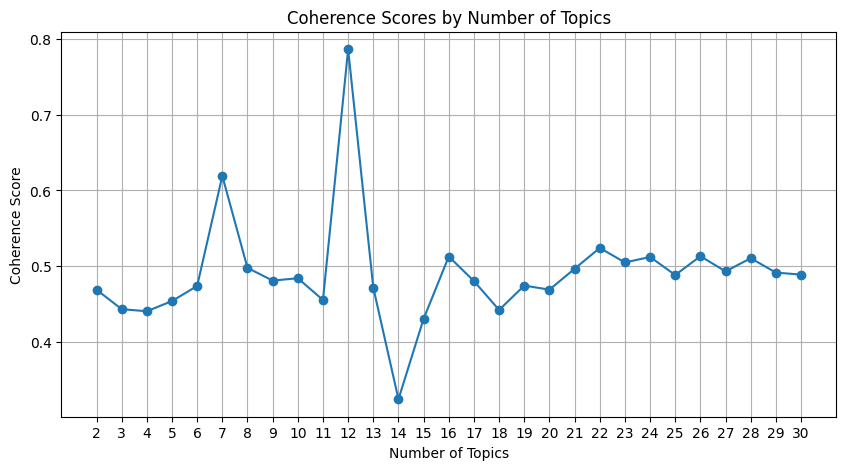

12

In [9]:
%matplotlib inline
find_optimal_number_of_topics(corpus=abstracts, start=2, end=len(abstracts), step=1, num_words=7)

We can see that the number of topics with more coherence is 12. We will try and see the lda model with 12 topics.

In [10]:
from topic_modeling.lda import LDA
lda_model = LDA(corpus=abstracts, num_topics=12, num_words=7)
lda_model.fit()

In [11]:
# Print the generated topics
print(f'\n> Generated {len(lda_model.topics)} topics:')
for i, topic in enumerate(lda_model.topics):
    print(f'> Topic {i}: {topic}')


> Generated 12 topics:
> Topic 0: ['investigación', 'resultados', 'poder', 'producción', 'doctoral', 'autor', 'presenta']
> Topic 1: ['investigación', 'resultados', 'poder', 'producción', 'doctoral', 'autor', 'presenta']
> Topic 2: ['investigación', 'resultados', 'poder', 'producción', 'doctoral', 'autor', 'presenta']
> Topic 3: ['escape', 'rates', 'nonmonotonic', 'increases', 'function', 'size', 'atmospheric']
> Topic 4: ['investigación', 'resultados', 'poder', 'producción', 'doctoral', 'autor', 'presenta']
> Topic 5: ['the', 'of', 'and', 'water', 'in', 'to', 'de']
> Topic 6: ['the', 'of', 'and', 'to', 'we', 'in', 'is']
> Topic 7: ['investigación', 'resultados', 'poder', 'producción', 'doctoral', 'autor', 'presenta']
> Topic 8: ['and', 'the', 'of', 'to', 'in', 'this', 'tourism']
> Topic 9: ['investigación', 'resultados', 'poder', 'producción', 'doctoral', 'autor', 'presenta']
> Topic 10: ['investigación', 'resultados', 'poder', 'producción', 'doctoral', 'autor', 'presenta']
> Topic 1

We can see that some of the 12 topics are repeated, so we will try the next maxima (7).

In [12]:
from topic_modeling.lda import LDA
lda_model = LDA(corpus=abstracts, num_topics=7, num_words=7)
lda_model.fit()

In [13]:
# Print the generated topics
print(f'\n> Generated {len(lda_model.topics)} topics:')
for i, topic in enumerate(lda_model.topics):
    print(f'> Topic {i}: {topic}')


> Generated 7 topics:
> Topic 0: ['and', 'the', 'in', 'we', 'of', 'for', 'with']
> Topic 1: ['presenta', 'autor', 'algunos', 'poder', 'resultados', 'producción', 'narcotráfico']
> Topic 2: ['and', 'our', 'the', 'work', 'with', 'in', 'attention']
> Topic 3: ['escape', 'rates', 'nonmonotonic', 'function', 'increases', 'radius', 'size']
> Topic 4: ['presenta', 'autor', 'algunos', 'poder', 'resultados', 'producción', 'narcotráfico']
> Topic 5: ['the', 'of', 'and', 'water', 'in', 'de', 'to']
> Topic 6: ['the', 'of', 'and', 'to', 'in', 'we', 'is']


Topic 1 and 4 are the same.

In [14]:
# Obtain the topic distributions for every document inside the corpus
lda_model.predict_all()

# Print the topic distributions for all the documents
print('\n> Topic distributions for all the documents:')
for doc_id, doc_info in enumerate(lda_model.topic_distributions):
    print(f'Document {doc_id}:')
    for topic_id, topic_dist in doc_info.items():
        print(f'> Topic {topic_id}: {topic_dist}')


> Topic distributions for all the documents:
Document 0:
> Topic 0: 0.001223133301034145
> Topic 1: 0.0012210158350775171
> Topic 2: 0.0012219955513241608
> Topic 3: 0.001221153107658179
> Topic 4: 0.0012210158350775171
> Topic 5: 0.9926668429615623
> Topic 6: 0.001224843408266074
Document 1:
> Topic 0: 0.0011182814759803305
> Topic 1: 0.0011160923594238353
> Topic 2: 0.0011172349412816684
> Topic 3: 0.0011170007286902962
> Topic 4: 0.0011160923594238353
> Topic 5: 0.0011176492352645646
> Topic 6: 0.9932976488999355
Document 2:
> Topic 0: 0.9953628711968974
> Topic 1: 0.0007722052355944785
> Topic 2: 0.0007726546823915904
> Topic 3: 0.0007724590586179395
> Topic 4: 0.0007722052355944785
> Topic 5: 0.0007734661168093662
> Topic 6: 0.0007741384740946191
Document 3:
> Topic 0: 0.0005265364583978198
> Topic 1: 0.0005252194324950237
> Topic 2: 0.0005255326322398832
> Topic 3: 0.0005252658289553407
> Topic 4: 0.0005252194324950237
> Topic 5: 0.0005259507484594575
> Topic 6: 0.99684627546695